<a href="https://colab.research.google.com/github/Burningzabidan/kims_bearing/blob/main/%5B%E1%84%87%E1%85%A6%E1%84%8B%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6%5D%E1%84%80%E1%85%A1%E1%86%BC%E1%84%83%E1%85%A9_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
from torchvision import transforms

import os
import cv2
from PIL import Image
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#1. 인장 시험 데이터 가져오기 및 정리

In [3]:
def pre_proc(file_dir:str) -> pd.DataFrame:
    """
    인장 시험 파일 불러오기
    불필요한 문자 삭제
    파일 df화
    """
    # load tensile test result
    f = open(file_dir,"r")
    lines = f.readlines()
    new_lines = []

    # \n, 공백 삭제
    for line in lines:
      new_lines.append(re.sub('[\n| ]', '', line))

    # df로 만들기
    new_lines_np = np.array(new_lines).reshape(-1,6)
    tensile_res = [[] for _ in range(4)]
    for i in range(len(new_lines_np)):
      for j in new_lines_np[i]:
        if re.match('[가-힣]',j):
          if tensile_res[i%4] == []:
            tensile_res[i%4].append(j)
        else:
          tensile_res[i%4].append(j)

    tensile_res = np.array(tensile_res).reshape(4,-1)
    df_tensile_res = pd.DataFrame(tensile_res[1:,1:], index = tensile_res[1:,0])
    df_tensile_res.columns = tensile_res[0,1:]
    df_tensile_res
    return df_tensile_res

df_tensile_res = pre_proc("./properties/tensile_test_result.txt")
# check the result
df_tensile_res

,1-1,1-2,1-3,1-4,1-5,2-1,2-2,2-3,2-4,2-5,...,4-1,4-2,4-3,4-4,4-5,5-1,5-2,5-3,5-4,5-5
인장강도N/mm2,1527,1439,1445,1421,1429,1200,1225,1256,1211,1253,...,1004,1004,1033,1019,994,896,882,918,897,928
항복강도(0.2%offset)N/mm2,1454,1359,1381,1354,1369,1113,1128,1186,1117,1170,...,907,902,927,916,896,816,780,826,831,845
연신율(GL:50mm)%,11,13,12,13,13,14,14,14,15,15,...,19,18,16,18,19,21,21,21,21,20


In [4]:
def get_linked_prop(df:pd.DataFrame) -> dict:
  """
  df로 정리된 인장 시험 결과를 샘플 시리즈를 keyword로,
  물성 별 측정값을 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  properties = {}
  for i in range(1,6):
    properties[i] = {}
    for j in ("TS", "YS", "EL"):
      properties[i][j] = []

  # df로부터 시리즈별 물성을 연결 리스트에 저장
  for m in df_tensile_res.columns:
    for k,l in enumerate(["TS", "YS", "EL"]):
      p = int(df_tensile_res[m][k])
      properties[int(m[0])][l].append(p)
  return properties

properties = get_linked_prop(df_tensile_res)
# check the result
print(f"sample series:{list(properties.keys())}")
print(f"properties of each series:{list(properties[1].keys())}")
len_TS = len(properties[1]["TS"])
print(f"number of TS data:{len_TS}")

sample series:[1, 2, 3, 4, 5]
properties of each series:['TS', 'YS', 'EL']
number of TS data:5


#2. 이미지 데이터 가져오기 및 정리

number of sample series:5
number of sample subseries:150
size of images:(448, 448, 3)


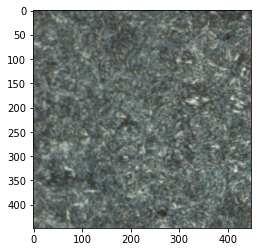

In [5]:
### 연결 리스트로 샘플 시리즈별 이미지 정리

def get_lined_img(files_dir:str) -> dict:
  """
  이미지를 불러와서 샘플 시리즈를 keyword,
  이미지를 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  imgs = {}
  for i in range(1,6):
    imgs[i] = []

  # 이미지를 크롭하여 시리즈별로 연결 리스트에 저장
  files = [f for f in os.listdir(files_dir) if "tif" in f]
  for file in files:
    img = (cv2.imread(files_dir+file)/255).astype(np.float32)
    h,w,c = img.shape
    for dx in range(0,h-448,56):
      for dy in range(0,w-448,56):
        img_crop = img[dx:dx+448,dy:dy+448]
        series = int(file[0])
        imgs[series].append(img_crop)

  return imgs

imgs = get_lined_img("./images/")

# check the result
print(f"number of sample series:{len(imgs)}")
print(f"number of sample subseries:{len(imgs[1])}")
print(f"size of images:{imgs[1][0].shape}")

# plot example
plt.figure(figsize = (4,4))
plt.imshow(imgs[1][0])

# 3. 이미지 별 물성 생성


In [6]:
### 연결 리스트로 생성된 물성 저장

def alloc_prop(imgs:dict, properties:dict) -> dict:
  """
  이미지가 해당 시리즈의 물성의 최대 최소 값 사이의 값을 가지도록
  물성 값을 랜덤하게 생성후 할당
  """
  # 빈 연결 리스트 생성
  props = {}
  for i in range(1,6):
    props[i] = {}
    for j in ("TS", "YS", "EL"):
      props[i][j] = []

  # 난수 시드 고정
  np.random.seed(0)

  # 생선된 물성 (propserated) 연결 리스트에 저장
  for i in range(1,6):
    for j in ("TS", "YS", "EL"):
      n_min = min(properties[i][j])
      n_max = max(properties[i][j])
      n_imgs = len(imgs[i])
      for _ in range(n_imgs):
        prop_gen = random.choice(range(n_min, n_max+1))
        props[i][j].append(prop_gen)
  return props

props = alloc_prop(imgs,properties)

# check the result
print(f"number of sample series:{list(props.keys())}")
print(f"number of properties:{list(props[1].keys())}")
num_data = [len(props[i]["TS"]) for i in props]
print(f"number of data:{sum(num_data), num_data}")

number of sample series:[1, 2, 3, 4, 5]
number of properties:['TS', 'YS', 'EL']
number of data:(600, [150, 150, 150, 150, 0])


In [7]:
def stack_props(target:str, properties:dict) -> np.array:
  res = []
  for i in props:
    res.extend(props[i][target])
  return np.array(res)

y = stack_props("TS", props)
y = (y-min(y))/ (max(y)-min(y)) # min = 0, max = 1 normalization
print(f"len, min, max of y: {len(y),min(y),max(y)}")

len, min, max of y: (600, 0.0, 1.0)


In [8]:
def stack_imgs(imgs:dict) -> np.array:
  # 이미지 총 갯수 구하기
  n = sum([len(imgs[i]) for i in imgs])
  # 이미지 차원 구하기
  h,w,c = imgs[1][0].shape # 1번째 시리즈의 1번째 이미지
  # 빈 이미지 변수 생성 -> 미리 만들어주는게 효율적
  imgs_stack = np.empty((n,h,w,c))

  # 이미지 쌓기
  idx = 0
  for i in imgs:
    for img in imgs[i]:
      imgs_stack[idx] = img
      idx += 1
  return imgs_stack

X = stack_imgs(imgs)
print(len(X))

600


# 4. 데이터 전처리

In [9]:
# 훈련 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 0)
print(f"shape of X_train:{X_train.shape}")
print(f"shape of X_test:{X_test.shape}")
print(f"shape of y_train:{y_train.shape}")
print(f"shape of y_test:{y_test.shape}")
print("-"*50)
# 이미지 데이터 정규화
img_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225],
            ),
        ])

# 이미지 데이터 클래스 정의
class img_dataset(Dataset):
  def __init__(self,x,y,transform):
    self.x = x
    self.y = y
    self.T = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.T(self.x[idx]), self.y[idx]

# 데이터로더에 훈련데이터 격납
train_dataset = img_dataset(X_train, y_train, img_transformer)
test_dataset = img_dataset(X_test, y_test, img_transformer)
train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = True)

# 결과 확인
# tmp = list(iter(train_loader))
# print(f"shape of train batch imgs:{tmp[0][0].shape}")
# print(f"shape of train batch labels:{tmp[0][1].shape}")
# plt.figure(figsize = (4,4))
# plt.imshow(tmp[0][0][0].permute(1,2,0)) # 1st img of the batch

shape of X_train:(540, 448, 448, 3)
shape of X_test:(60, 448, 448, 3)
shape of y_train:(540,)
shape of y_test:(60,)
--------------------------------------------------


#5. 모델링

In [10]:
# loading resnet101
my_model = models.resnet101(pretrained = True)

# change in and out features of fc layer
in_features = my_model.fc.in_features
out_features = 1
my_model.fc = nn.Linear(in_features, out_features)

# freeze parameters when training
for params in my_model.parameters():
  params.requires_grad = True

# unfreeze parameters of fc layer when training
for params in my_model.fc.parameters():
  params.requires_grad = True

# model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 6. 모델 훈련

In [11]:
# 파라미터 설정
n_epoch = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(my_model.parameters(), lr = 0.00001)

train_loss_lst = []
val_loss_lst = []
for i in range(n_epoch):
  for j,[x,y] in enumerate(train_loader):
    x = x.to(device).to(torch.float32)
    y = y.unsqueeze(1).to(device).to(torch.float32)

    optimizer.zero_grad()
    y_pred = my_model(x)
    loss = criterion(y,y_pred)
    loss.backward()
    optimizer.step()

    train_loss_lst.append(loss.item())


    with torch.no_grad():
      val_loss = 0
      n = 0
      for k, [x_test, y_test] in enumerate(test_loader):
        x_test = x_test.to(device).to(torch.float32)
        y_test = y_test.to(device).to(torch.float32)
        y_test_pred = my_model(x_test).squeeze(1)
        loss_test = criterion(y_test, y_test_pred)
        val_loss += loss_test.item()
        n+=1
    val_loss /= n
    val_loss_lst.append(val_loss)

    # 훈련 진행 상황 출력
    print(f"i:{i}    j:{j}    train_loss:{loss.item():.4f}    val_loss:{val_loss:.3f}    y_val:{y_test[0].item():.3f}    y_val_pred:{y_test_pred[0].item():.3f}")

    # 모델 저장
    if i >= 1 and loss.item() == min(train_loss_lst):
      print("train model saved")
      torch.save(my_model.state_dict(), "./model/train_best_model.pth")

    if i >= 1  and val_loss == min(val_loss_lst):
      print("test model saved")
      torch.save(my_model.state_dict(), "./model/test_best_model.pth")

print("last model saved")
torch.save(my_model.state_dict(), "./model/last_model.pth")

    

/compuworks/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


i:0    j:0    train_loss:0.0447    val_loss:0.130    y_val:0.266    y_val_pred:0.053
i:0    j:1    train_loss:0.1441    val_loss:0.109    y_val:0.212    y_val_pred:0.016
i:0    j:2    train_loss:0.1169    val_loss:0.097    y_val:0.030    y_val_pred:-0.160
i:0    j:3    train_loss:0.2206    val_loss:0.078    y_val:0.028    y_val_pred:-0.178
i:0    j:4    train_loss:0.0153    val_loss:0.069    y_val:0.477    y_val_pred:0.184
i:0    j:5    train_loss:0.0477    val_loss:0.050    y_val:0.212    y_val_pred:0.090
i:0    j:6    train_loss:0.0748    val_loss:0.054    y_val:0.019    y_val_pred:0.030
i:0    j:7    train_loss:0.0320    val_loss:0.047    y_val:0.285    y_val_pred:0.140
i:0    j:8    train_loss:0.0387    val_loss:0.042    y_val:0.019    y_val_pred:-0.194
i:0    j:9    train_loss:0.0602    val_loss:0.037    y_val:0.311    y_val_pred:0.097
i:0    j:10    train_loss:0.0197    val_loss:0.039    y_val:0.009    y_val_pred:-0.038
i:0    j:11    train_loss:0.0309    val_loss:0.036    y_val:

#7. 훈련 결과 플롯

In [13]:
def get_pred(model, dataloader:DataLoader, pretrained:str = None)-> list:

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"

    if pretrained != None:
        model.load_state_dict(torch.load(pretrained, "cuda"))
    model = nn.DataParallel(model)
    model.to(device)

    y_lst = []
    y_pred_lst = []

    for i,j in dataloader:
        j = j.tolist()
        y_lst.extend(j)
        y_pred = model(i.to(device).to(torch.float32))
        y_pred = y_pred.squeeze(1).to("cpu").tolist()
        y_pred_lst.extend(y_pred)

    return y_lst, y_pred_lst

def denormalize(lst:list) -> list:
    s_props = stack_props("TS", props)
    n_min = min(s_props)
    n_max = max(s_props)

    res = []
    for i in lst:
        res.append((n_max-n_min)*i + n_min)
    return res

def get_rmse(x:list,y:list) -> float:
    rmse = np.array(x)- np.array(y)
    rmse = np.square(rmse).sum()/len(x)
    rmse = np.power(rmse,0.5)
    return rmse

train_rsme:83.17993414682275
test_rsme:78.71001356974566


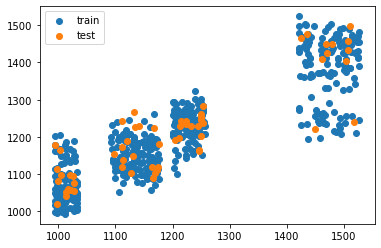

In [14]:
y_lst, y_pred_lst = get_pred(my_model, train_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "train")
print(f"train_rsme:{get_rmse(y_lst,y_pred_lst)}")

y_lst, y_pred_lst = get_pred(my_model, test_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "test")
print(f"test_rsme:{get_rmse(y_lst,y_pred_lst)}")

plt.legend()